In [55]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [56]:



transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])



trainset = datasets.SVHN('data', split="train", download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.SVHN('data', split="test", download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=6128, shuffle=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [57]:
image, label = next(iter(trainloader))
print(len(trainset))
print(len(testset))



73257
26032


In [58]:
image.shape
(image.view(image.shape[0],-1)).shape


torch.Size([128, 3072])

In [59]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from tqdm import tqdm



class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params


In [60]:
model = Classifier()
model = model.to(device)

criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
steps = 0
cm = [ [ 0 for i in range(10) ] for j in range(10) ]


train_losses, test_losses = [], []
train_acc, test_acc =[],[]
Norm_grad = []        
for e in range(epochs):

    running_loss = 0
    accuracy2 = 0
    total_norm=0
    for images, labels in trainloader:
        images= images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        log_ps = model(images)        
        loss = criterion(log_ps, labels)
        loss.backward()
        
        optimizer.step()
        with torch.no_grad(): 
          model.eval()
          log_ps2 = log_ps.clone().detach()               
          ps2 = torch.exp(log_ps2)
          top_p2, top_class2 = ps2.topk(1, dim=1)
          equals2 = top_class2 == labels.view(*top_class2.shape)
          accuracy2 += torch.mean(equals2.type(torch.FloatTensor))
          norm=0
          for p in model.parameters():
              param_norm = p.grad.data.norm(2)
              norm += param_norm.item() ** 2
          total_norm += norm ** (1. / 2)      


        model.train()        
        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            model.eval()
            for images, labels in testloader:
                images= images.to(device)
                labels = labels.to(device)             
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                cm += confusion_matrix(labels.view(*top_class.shape).cpu(), top_class.cpu())
                

        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        train_acc.append(accuracy2/len(trainloader))
        test_acc.append(accuracy/len(testloader))
        Norm_grad.append(total_norm)
        

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Train Accuracy: {:.3f}".format(accuracy2/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
              "Norm: {:.3f}".format(total_norm))
print(cm)
        


Epoch: 1/30..  Training Loss: 2.154..  Train Accuracy: 0.216 Test Loss: 1.969..  Test Accuracy: 0.285 Norm: 403.376
Epoch: 2/30..  Training Loss: 1.655..  Train Accuracy: 0.409 Test Loss: 1.611..  Test Accuracy: 0.450 Norm: 1868.856
Epoch: 3/30..  Training Loss: 1.466..  Train Accuracy: 0.495 Test Loss: 1.663..  Test Accuracy: 0.458 Norm: 2026.760
Epoch: 4/30..  Training Loss: 1.379..  Train Accuracy: 0.535 Test Loss: 1.443..  Test Accuracy: 0.532 Norm: 1983.721
Epoch: 5/30..  Training Loss: 1.290..  Train Accuracy: 0.572 Test Loss: 1.341..  Test Accuracy: 0.574 Norm: 2108.891
Epoch: 6/30..  Training Loss: 1.202..  Train Accuracy: 0.613 Test Loss: 1.317..  Test Accuracy: 0.591 Norm: 2049.836
Epoch: 7/30..  Training Loss: 1.161..  Train Accuracy: 0.628 Test Loss: 1.290..  Test Accuracy: 0.601 Norm: 2046.760
Epoch: 8/30..  Training Loss: 1.140..  Train Accuracy: 0.635 Test Loss: 1.256..  Test Accuracy: 0.604 Norm: 2066.461
Epoch: 9/30..  Training Loss: 1.118..  Train Accuracy: 0.644 Test

In [61]:
import numpy as np
def view_classify(img, ps, version="SVHN"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "SVNH":
        ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

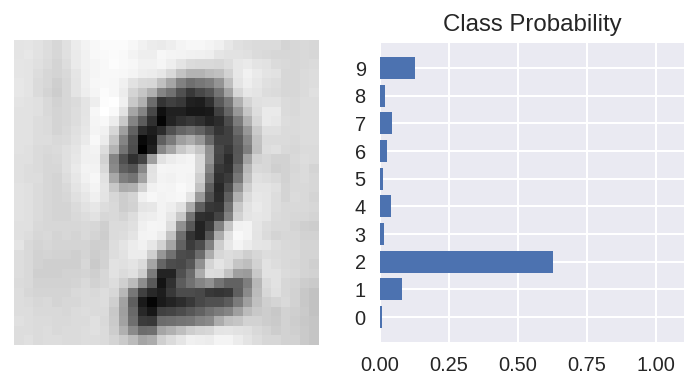

In [62]:

model = model.cpu()
model.eval()


dataiter = iter(testloader)
images, labels = dataiter.next()

img = images[0]

img = img.view(1, 3072)


with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
view_classify(img.view(3, 32, 32), ps, version='SVNH')


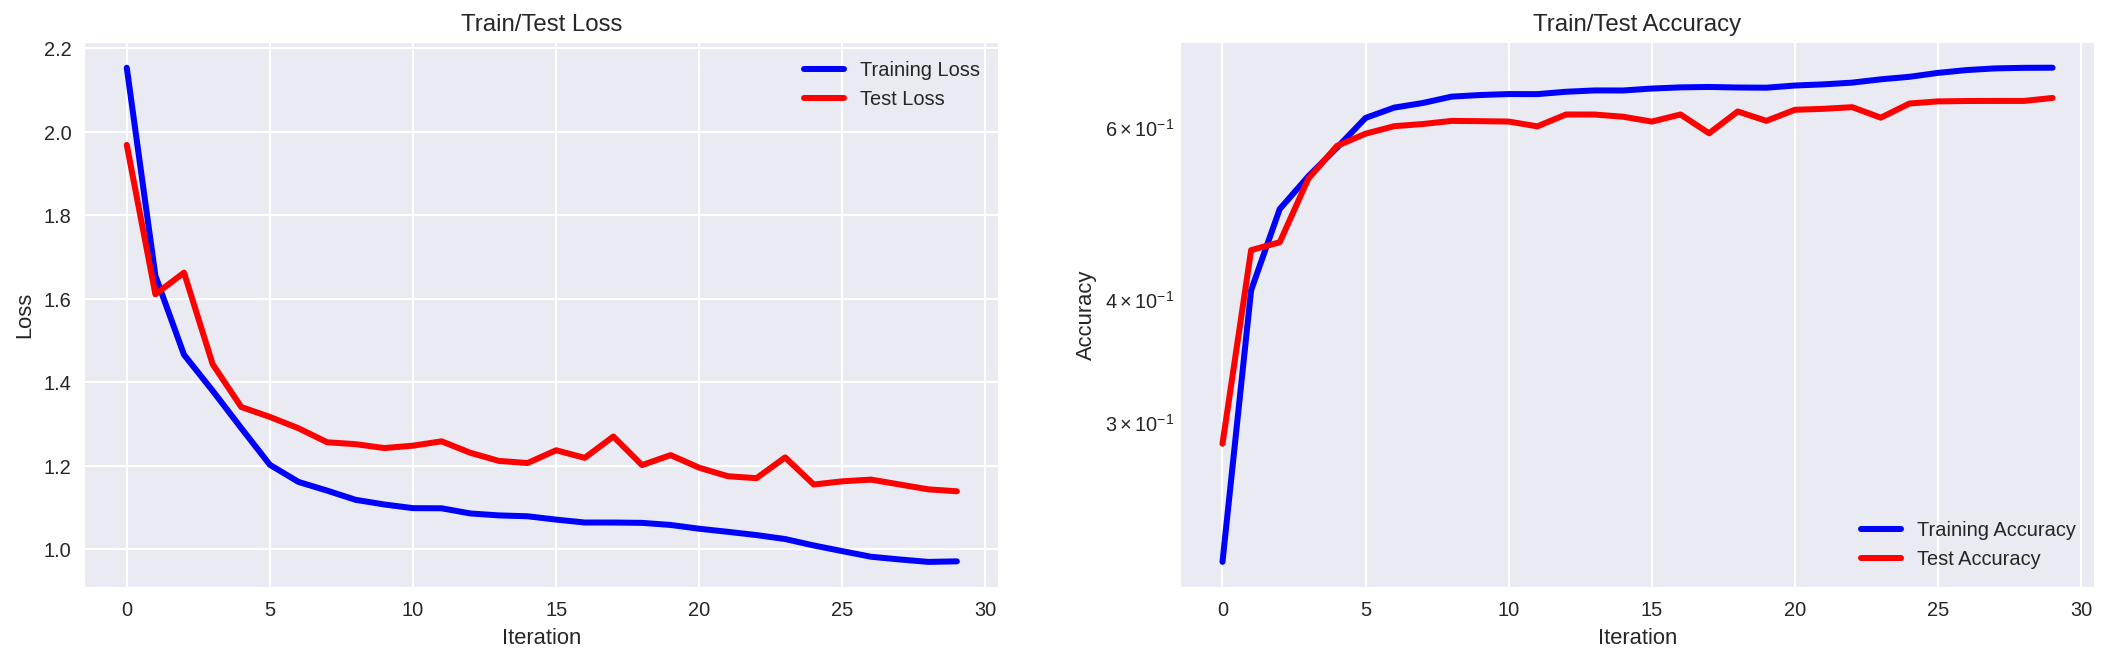

In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt



plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)


ax[0].plot(train_losses, c="blue", label="Training Loss", linewidth=3)
ax[0].plot(test_losses, c="red", label="Test Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].set_title("Train/Test Loss")

ax[1].plot(train_acc, c="blue", label="Training Accuracy", linewidth=3)
ax[1].plot(test_acc, c="red", label="Test Accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")
ax[1].set_yscale("log")
ax[1].set_title("Train/Test Accuracy")

plt.show()

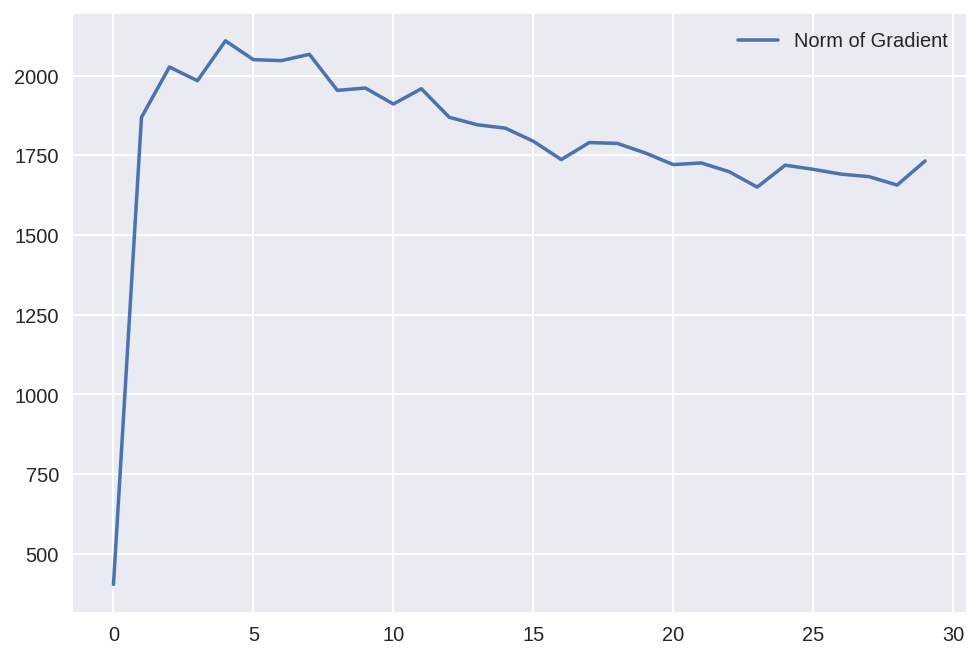

In [64]:
plt.plot(Norm_grad, label='Norm of Gradient')

plt.legend(frameon=False)

In [66]:
!pip install optuna

     |████████████████████████████████| 308 kB 11.3 MB/s 
     |████████████████████████████████| 209 kB 28.4 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 148 kB 51.9 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 41.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=84499303786b888cec1cf2b9e0b472614398f03c0ac2ba146df8e28131d5483c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [71]:
import optuna
def objective (trial):


  model = Classifier()


  criterion = nn.NLLLoss()

  lr = trial.suggest_loguniform("lr", 5e-4, 1e-3)
  print(lr)
  epochs = trial.suggest_int("epochs", 15, 30)
  print(epochs)


  optimizer = optim.Adam(model.parameters(), lr= lr)

  steps = 0


  train_losses, test_losses = [], []
  for e in range(epochs):
      running_loss = 0
      for images, labels in trainloader:
        
          optimizer.zero_grad()
        
          log_ps = model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
        
          running_loss += loss.item()
      else:
          test_loss = 0
          accuracy = 0
        
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              model.eval()
              for images, labels in testloader:
                  log_ps = model(images)
                  test_loss += criterion(log_ps, labels)
                
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
        
          model.train()
        
          train_losses.append(running_loss/len(trainloader))
          test_losses.append(test_loss/len(testloader))

          # print("Epoch: {}/{}.. ".format(e+1, epochs),
          #       "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          #       "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          #       "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  plt.plot(train_losses, label='Training loss')
  plt.plot(test_losses, label='Validation loss')
  plt.legend(frameon=False)
  plt.show()
  return (accuracy/len(testloader))

[I 2021-11-15 02:11:00,322] A new study created in memory with name: no-name-55ca2493-6127-46c1-9325-b5f953f8c941


0.0009422300896965974
28


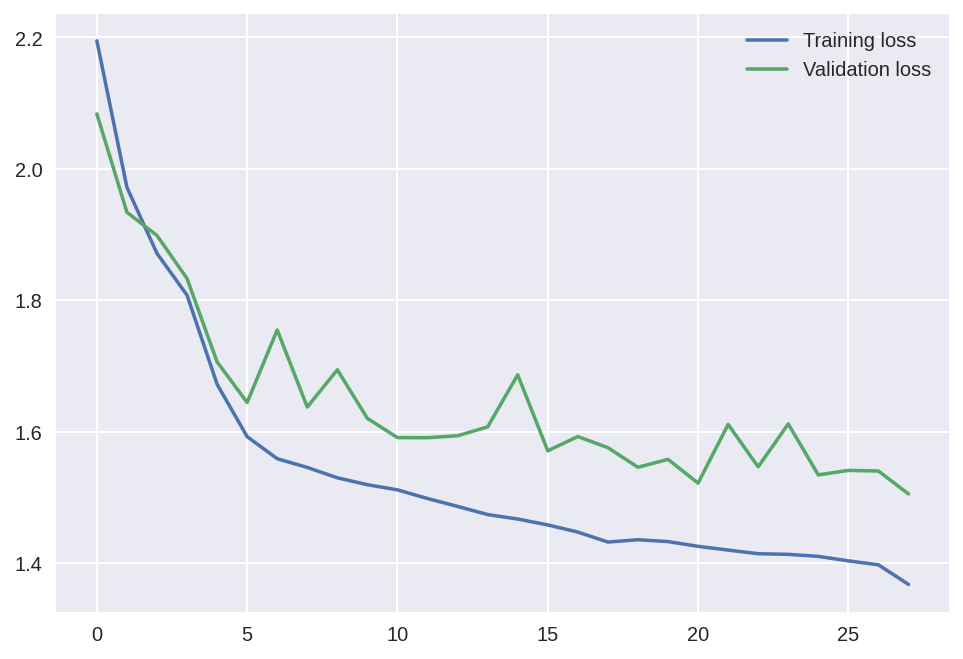

[I 2021-11-15 02:25:39,739] Trial 0 finished with value: 0.493264377117157 and parameters: {'lr': 0.0009422300896965974, 'epochs': 28}. Best is trial 0 with value: 0.493264377117157.


0.0005658959968917299
15


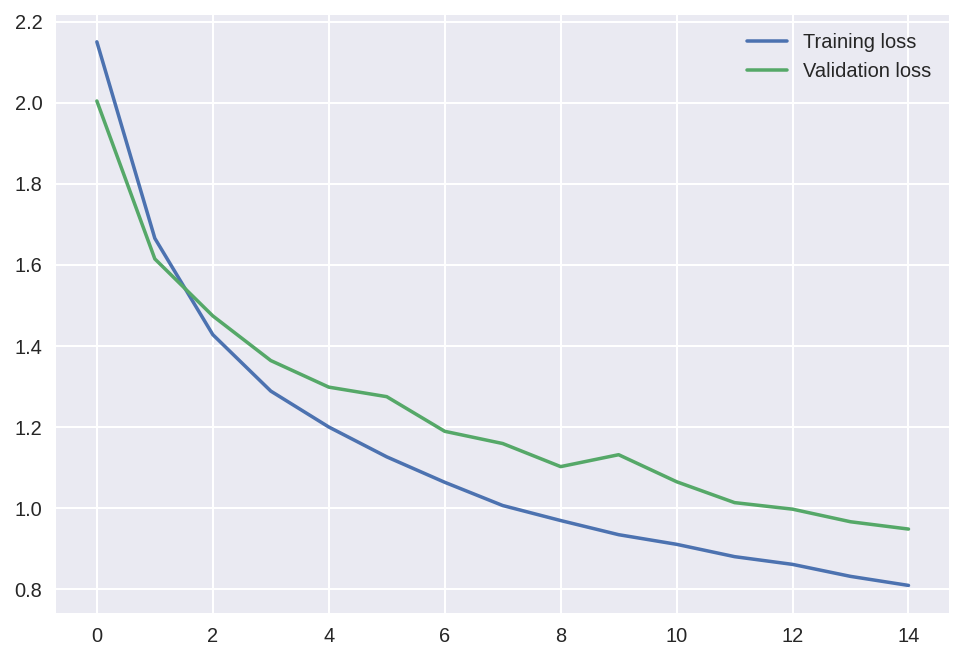

[I 2021-11-15 02:33:18,782] Trial 1 finished with value: 0.7215439081192017 and parameters: {'lr': 0.0005658959968917299, 'epochs': 15}. Best is trial 1 with value: 0.7215439081192017.


0.0008653713377358177
25


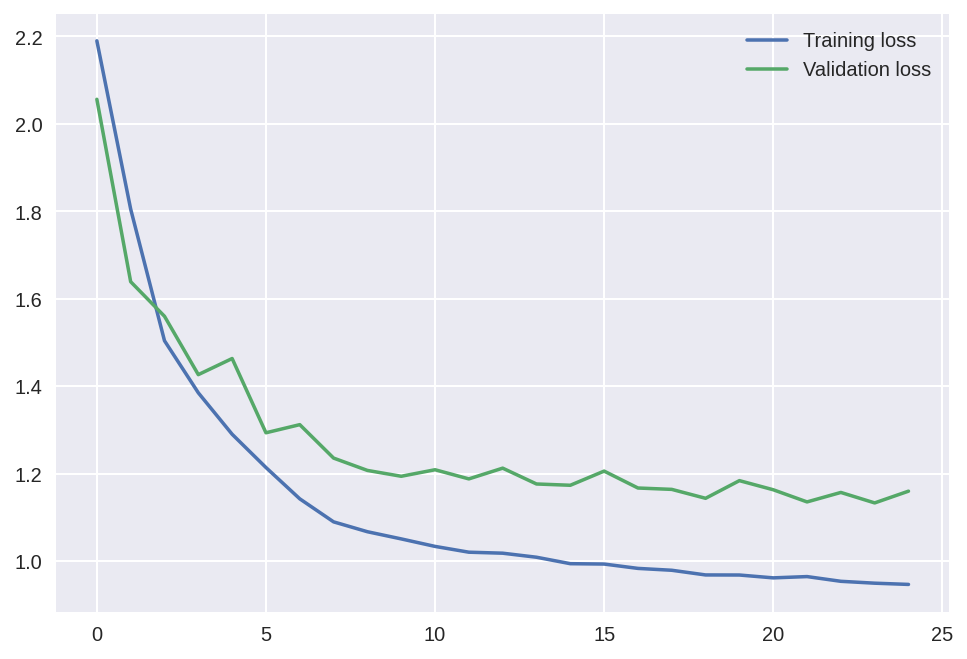

[I 2021-11-15 02:46:12,172] Trial 2 finished with value: 0.6418489217758179 and parameters: {'lr': 0.0008653713377358177, 'epochs': 25}. Best is trial 1 with value: 0.7215439081192017.


0.0008487665712872607
16


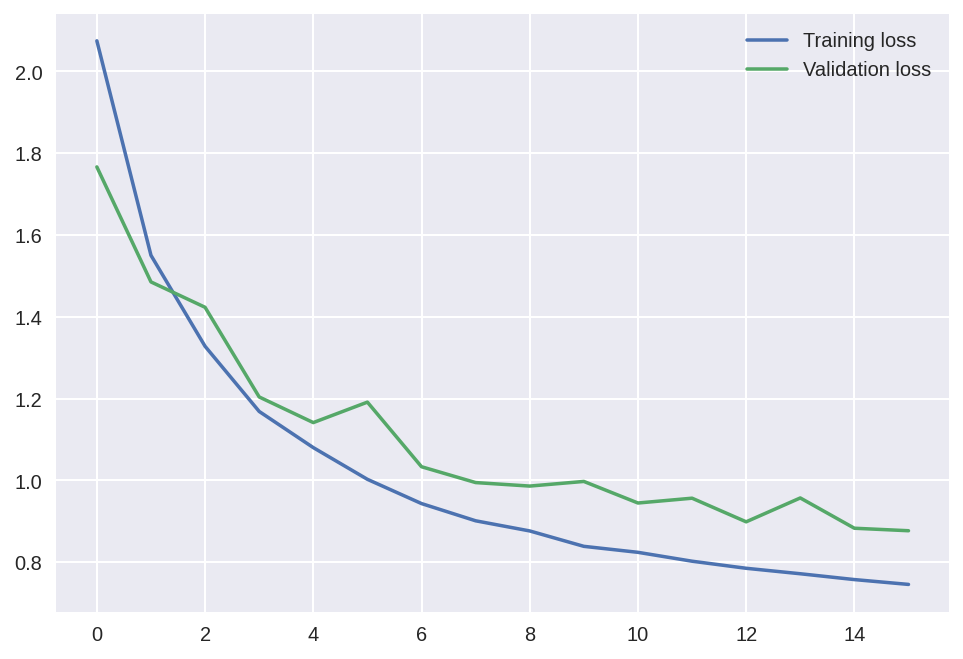

[I 2021-11-15 02:54:19,803] Trial 3 finished with value: 0.742323100566864 and parameters: {'lr': 0.0008487665712872607, 'epochs': 16}. Best is trial 3 with value: 0.742323100566864.


0.0007448327629279926
21


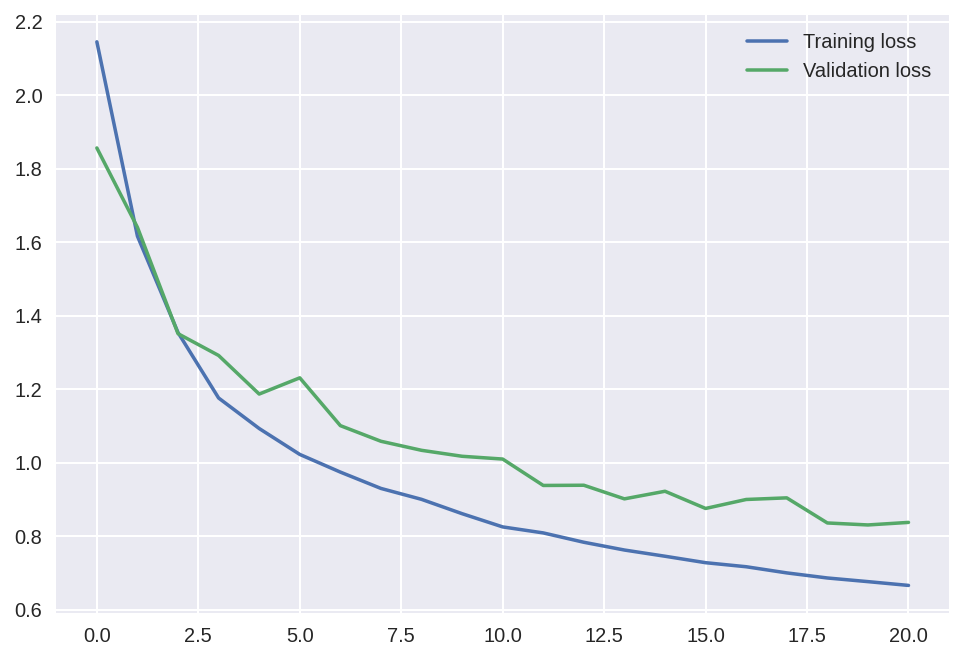

[I 2021-11-15 03:05:10,003] Trial 4 finished with value: 0.7502047419548035 and parameters: {'lr': 0.0007448327629279926, 'epochs': 21}. Best is trial 4 with value: 0.7502047419548035.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.7502047419548035
  Params: 
    lr: 0.0007448327629279926
    epochs: 21


/usr/local/lib/python3.7/dist-packages/optuna/structs.py:18: FutureWarning:

`structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.



In [72]:
study = optuna.create_study(direction="maximize")
study.optimize(objective ,n_trials=5)

pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))